In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load Qwen Coder Model and Tokenizer
model_name = "Qwen/Qwen2.5-Coder-3B"  # Replace with the exact model name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [2]:
# Extract Embedding Layer
embedding_layer = model.get_input_embeddings()

# Define Tokens to Compare (e.g., Synonyms and Unrelated Words)
words = ["quick", "fast", "slow", "happy", "joyful", "sad", "run", "jog", "walk"]


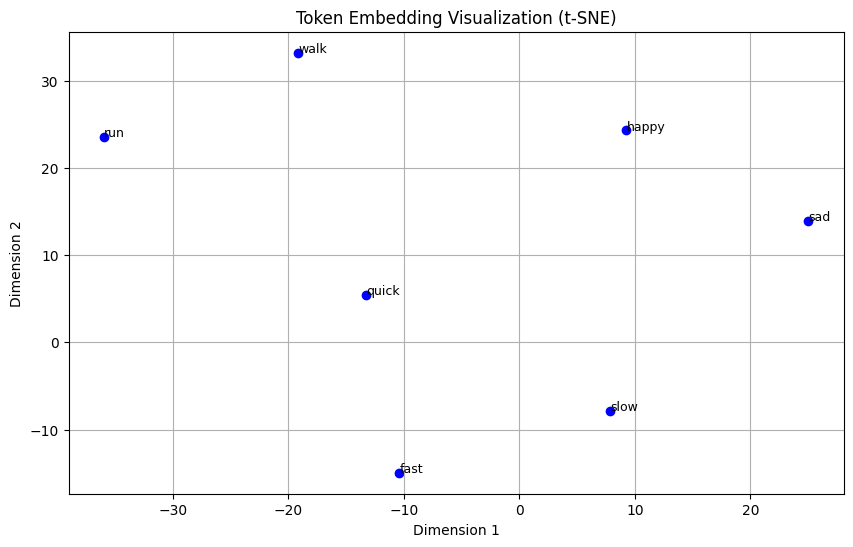

In [3]:
# Tokenize Words and Select the First Token for Each Word
tokens = []
valid_words = []
for word in words:
    token_ids = tokenizer(word, add_special_tokens=False)["input_ids"]
    if len(token_ids) == 1:  # Ensure only single-token words are considered
        tokens.append(token_ids[0])
        valid_words.append(word)

tokens = torch.tensor(tokens)

# Get Embeddings for the Selected Tokens
with torch.no_grad():
    embeddings = embedding_layer(tokens).cpu().numpy()

# Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Adjusted perplexity
reduced_embeddings = tsne.fit_transform(embeddings)

# Visualization
def plot_embeddings(embeddings, words):
    plt.figure(figsize=(10, 6))
    for i, word in enumerate(words):
        x, y = embeddings[i]
        plt.scatter(x, y, marker='o', color='blue')
        plt.text(x + 0.02, y + 0.02, word, fontsize=9)
    plt.title("Token Embedding Visualization (t-SNE)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

plot_embeddings(reduced_embeddings, valid_words)

In [3]:
vocab_size = len(tokenizer)
token_ids = torch.arange(vocab_size)

with torch.no_grad():
    all_embeddings = embedding_layer(token_ids).detach().cpu().numpy()
print(all_embeddings.shape)

query_tokens = ["python", "java", "def", "if","torch","transformers","for","pytorch","import"]

def test(query_tokens):
    n_neighbors = 20  
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
    knn.fit(all_embeddings)
    query_ids = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word)[0]) for word in query_tokens]
    query_embeddings = embedding_layer(torch.tensor(query_ids)).detach().cpu().numpy()
    
    distances, indices = knn.kneighbors(query_embeddings)
    
    for i, word in enumerate(query_tokens):
        print(f"\nClosest tokens to '{word}':")
        for idx, dist in zip(indices[i], distances[i]):
            token = tokenizer.convert_ids_to_tokens(int(idx))  # Convert NumPy integer to Python integer
            print(f"  Token: {token}, Distance: {dist:.4f}")


(151665, 2048)


In [4]:
import numpy as np

# Compute cosine similarity of two numpy arrays
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# Return a list of the distance between word and all element in embeddings
def compute_distance(word,embeddings):
    token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word)[0])
    token_embedding = embedding_layer(torch.tensor(token_id)).detach().cpu().numpy()
    distances = []
    for e in range(embeddings.shape[0]):
        similarity = cosine_similarity(token_embedding,embeddings[e])
        distances.append(similarity)
    return distances

#word = '!'
#distances = compute_distance(word,all_embeddings)

In [5]:
# Give key statistics about the distance list
def distances_stats(distances):
    max = np.max(distances)
    min = np.min(distances)
    std = np.std(distances)
    avg = np.mean(distances)
    return min,max,std,avg

#distances_stats(distances)

In [6]:
#for each word in the list word1 look for the closest word in words2
#if a word is in both set it won't give the same word a closeset but a distinct word
def find_pair(words1, words2):
    token_ids2 = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word)[0]) for word in words2]
    token_embeddings2 = np.array([embedding_layer(torch.tensor(token_id)).detach().cpu().numpy() for token_id in token_ids2])
    res_list = []
    for word in words1:
        distances = compute_distance(word,token_embeddings2)
        index = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word)[0])
        if index in token_ids2:
            index = token_ids2.index(index)
            # since cosine similarity min is -1 I'm sure i won't get this as the max similarity
            distances[index]= -2
        idx = np.argmax(distances)
        res = words2[idx]
        res_list.append(res)
    return res_list

In [7]:
import pandas as pd

df = pd.read_parquet("hf://datasets/bigcode/programming-languages-keywords/data/train-00000-of-00001-2a6aa307b284c516.parquet")

In [8]:
df

,language,keywords
0,C (ANSI (C89),"[auto, break, case, char, const, continue, def..."
1,C (C11,"[Alignas, Alignof, Atomic, Bool, Complex, Gene..."
2,C (C17,"[Alignas, Alignof, Atomic, Bool, Complex, Gene..."
3,C (C99,"[Bool, Complex, Imaginary, auto, break, case, ..."
4,C# (8.0,"[abstract, add, alias, as, ascending, async, a..."
5,C++ (C++03,"[and, asm, auto, bitand, bitor, bool, break, c..."
6,C++ (C++11,"[alignas, alignof, and, asm, assert, auto, bit..."
7,C++ (C++14,"[alignas, alignof, and, asm, assert, auto, bit..."
8,C++ (C++17,"[alignas, alignof, and, asm, assert, auto, bit..."
9,C++ (C++20,"[alignas, alignof, and, asm, assert, auto, awa..."


In [9]:
indices_to_drop = [0,1,2,5,6,7,8,9,11,12,13,14,16,18,19,20,21,24,25,26,28,34,35]
df.drop(df.index[df.index.isin(indices_to_drop)], inplace=True)
df

,language,keywords
3,C (C99,"[Bool, Complex, Imaginary, auto, break, case, ..."
4,C# (8.0,"[abstract, add, alias, as, ascending, async, a..."
10,C++ (C++98,"[and, asm, auto, bitand, bitor, bool, break, c..."
15,Go (1.18,"[break, case, chan, const, continue, default, ..."
17,Java (SE 17 LTS,"[abstract, assert, boolean, break, byte, case,..."
22,JavaScript (6th edition,"[await, break, case, catch, class, const, cont..."
23,Kotlin (1.4,"[abstract, actual, annotation, as, break, by, ..."
27,PHP (7.4,"[abstract, and, array, as, break, callable, ca..."
29,Python 3 (3.10,"[False, None, True, and, as, assert, async, aw..."
30,R (4.0,"[FALSE, Inf, NA, NULL, NaN, TRUE, break, chara..."


In [10]:
# Generate new columns containing the the most smilar keywords for the source language df['language'] to the target language (name of the column)
# do it for itself to we can see inside the language what are the closest pair of keywords
def new_df(df):
    for language in df['language']:
        keywords2 = df[df['language'] == language]['keywords'].to_list()[0]
        new_col = []
        for index, row in df.iterrows():
            keywords1 = row['keywords']
            exit()
            new_col.append(find_pair(keywords1,keywords2))
        df[str(language)] = new_col
    return df
df = new_df(df)

In [11]:
#df.to_csv('similarity.csv', index=False)

In [2]:
#df = pd.read_csv('/kaggle/input/languages/similarity.csv')

In [3]:
df

,language,keywords,C (C99,C# (8.0,C++ (C++98,Go (1.18,Java (SE 17 LTS,JavaScript (6th edition,Kotlin (1.4,PHP (7.4,Python 3 (3.10,R (4.0,Ruby (2.7,Rust (1.46,Scala (2.13
0,C (C99,['Bool' 'Complex' 'Imaginary' 'auto' 'break' '...,"['Complex', 'Bool', 'Complex', 'inline', 'cont...","['bool', 'abstract', 'implicit', 'explicit', '...","['bool', 'sizeof', 'short', 'inline', 'continu...","['struct', 'defer', 'import', 'const', 'contin...","['boolean', 'requires', 'implements', 'double'...","['false', 'throw', 'implements', 'static', 'co...","['false', 'abstract', 'import', 'inline', 'con...","['callable', 'abstract', 'implements', 'static...","['False', 'False', 'import', 'async', 'continu...","['TRUE', 'complex', 'Inf', 'function', 'else',...","['false', 'elsif', 'FILE', 'self', 'return', '...","['false', 'abstract', 'impl', 'Self', 'continu...","['false', 'abstract', 'implicit', 'implicit', ..."
1,C# (8.0,['abstract' 'add' 'alias' 'as' 'ascending' 'as...,"['enum', 'if', 'extern', 'if', 'unsigned', 'en...","['interface', 'remove', 'abstract', 'is', 'des...","['virtual', 'new', 'friend', 'asm', 'unsigned'...","['interface', 'if', 'interface', 'if', 'defer'...","['interface', 'new', 'abstract', 'if', 'sealed...","['interface', 'new', 'enum', 'in', 'implements...","['interface', 'get', 'abstract', 'is', 'sealed...","['interface', 'new', 'abstract', 'or', 'endfor...","['async', 'if', 'except', 'is', 'async', 'awai...","['complex', 'if', 'integer', 'in', 'integer', ...","['alias', 'end', 'until', 'in', 'elsif', 'def'...","['virtual', 'use', 'abstract', 'in', 'unsafe',...","['protected', 'new', 'abstract', 'if', 'sealed..."
2,C++ (C++98,['and' 'asm' 'auto' 'bitand' 'bitor' 'bool' 'b...,"['for', 'enum', 'inline', 'Bool', 'int', 'Bool...","['for', 'as', 'explicit', 'byte', 'sbyte', 'ui...","['or', 'enum', 'inline', 'bitor', 't', 'void',...","['for', 'goto', 'const', 'chan', 'if', 'const'...","['with', 'enum', 'double', 'byte', 'synchroniz...","['with', 'enum', 'static', 'case', 'in', 'void...","['for', 'as', 'inline', 'by', 'noinline', 'fal...","['or', 'as', 'static', 'xor', 'as', 'const', '...","['or', 'as', 'async', 'pass', 'in', 'False', '...","['for', 'break', 'function', 'break', 'in', 'F...","['or', 'break', 'self', 'begin', 'in', 'false'...","['for', 'as', 'Self', 'box', 'in', 'false', 'c...","['with', 'macro', 'implicit', 'case', 'if', 'f..."
3,Go (1.18,['break' 'case' 'chan' 'const' 'continue' 'def...,"['continue', 'switch', 'char', 'void', 'break'...","['continue', 'switch', 'char', 'var', 'break',...","['continue', 'cast', 'char', 'void', 'break', ...","['continue', 'switch', 'func', 'var', 'break',...","['continue', 'switch', 'char', 'var', 'break',...","['continue', 'switch', 'yield', 'var', 'break'...","['continue', 'catch', 'sealed', 'var', 'break'...","['continue', 'switch', 'trait', 'var', 'break'...","['continue', 'break', 'yield', 'class', 'break...","['else', 'break', 'character', 'function', 'br...","['return', 'break', 'yield', 'class', 'break',...","['continue', 'break', 'crate', 'let', 'break',...","['return', 'catch', 'sealed', 'var', 'throw', ..."
4,Java (SE 17 LTS,['abstract' 'assert' 'boolean' 'break' 'byte' ...,"['enum', 'while', 'Bool', 'continue', 'char', ...","['interface', 'throw', 'bool', 'continue', 'ch...","['virtual', 'throw', 'bool', 'continue', 'bita...","['interface', 'if', 'switch', 'continue', 'int...","['interface', 'throw', 'byte', 'continue', 'ch...","['interface', 'throw', 'void', 'continue', 'vo...","['interface', 'expect', 'false', 'continue', '...","['interface', 'print', 'final', 'continue', 'f...","['async', 'raise', 'False', 'continue', 'await...","['complex', 'while', 'integer', 'else', 'integ...","['alias', 'ensure', 'false', 'return', 'FILE',...","['virtual', 'while', 'false', 'continue', 'vir...","['protected', 'throw', 'false', 'return', 'fin..."
5,JavaScript (6th edition,['await' 'break' 'case' 'catch' 'class' 'const...,"['sizeof', 'continue', 'switch', 'else', 'stru...","['async', 